In [1]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import paddle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from paddlets.datasets import TimeSeries, TSDataset
from paddlets.models.representation.dl.ts2vec import TS2Vec
from paddlets.models.common.callbacks.callbacks import Callback
from paddlets.datasets.repository import get_dataset

## 准备数据集

In [ ]:
# 读取数据 & 拆分数据集
data = get_dataset('ETTh1') #公开数据集，电力行业，多变量时间序列
data, _ = data.split('2016-08-22 00:00:00')
train_data, test_data = data.split('2016-08-20 23:00:00')
data

                            OT    HUFL   HULL    MUFL   MULL   LUFL   LULL
date                                                                      
2016-07-01 00:00:00  30.531000   5.827  2.009   1.599  0.462  4.203  1.340
2016-07-01 01:00:00  27.787001   5.693  2.076   1.492  0.426  4.142  1.371
2016-07-01 02:00:00  27.787001   5.157  1.741   1.279  0.355  3.777  1.218
2016-07-01 03:00:00  25.044001   5.090  1.942   1.279  0.391  3.807  1.279
2016-07-01 04:00:00  21.948000   5.358  1.942   1.492  0.462  3.868  1.279
...                        ...     ...    ...     ...    ...    ...    ...
2016-08-21 20:00:00  27.787001  14.535  4.488   9.239  2.594  5.300  1.157
2016-08-21 21:00:00  27.506001  14.602  4.086  10.270  2.665  4.660  1.036
2016-08-21 22:00:00  27.997999  14.535  3.818  10.163  2.097  4.112  1.127
2016-08-21 23:00:00  27.716999  15.740  5.023  11.655  3.163  3.594  1.097
2016-08-22 00:00:00  27.506001  20.027  6.832  14.001  4.158  5.757  1.614

[1249 rows x 7 columns]

## 1 第一阶段：表征生成

### 1.1 表征模型训练


In [5]:
ts2vec = TS2Vec(
    segment_size=64, # 序列长度
    repr_dims=16,     # 表征维度
    batch_size=256,   
    max_epochs=5,
)

# training
np.random.seed(0)
paddle.seed(0)
ts2vec.fit(train_data)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/fluid/dygraph/math_op_patch.py:278: UserWarning: The dtype of left and right variables are not the same, left dtype is paddle.float32, but right dtype is paddle.int64, the right dtype will convert to paddle.float32
  format(lhs_dtype, rhs_dtype, lhs_dtype))
[2022-11-10 16:07:37,953] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 000| loss: 27.735917| 0:00:31s
[2022-11-10 16:08:19,499] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 001| loss: 12.918029| 0:01:13s
[2022-11-10 16:08:53,625] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 002| loss: 8.245859| 0:01:47s
[2022-11-10 16:09:25,645] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 003| loss: 5.424516| 0:02:19s
[2022-11-10 16:09:58,716] [paddlets.models.common.callbacks.callbacks] [INFO] epoch 004| loss: 4.954627| 0:02:52s


In [7]:
sliding_len = 100  # 用于对每个点生成表征所需的序列长度
all_reprs = ts2vec.encode(data, sliding_len=sliding_len)
split_tag = len(train_data['OT'])
train_reprs = all_reprs[:, :split_tag]
test_reprs = all_reprs[:, split_tag:]

100%|██████████| 1249/1249 [00:02<00:00, 566.86it/s]


In [8]:
train_reprs.shape, test_reprs.shape

((1, 1224, 16), (1, 25, 16))

## 2 第二阶段：下游任务

### 2.1 构建样本

In [9]:
def generate_pred_samples(features, data, pred_len, drop=0):
    """
    生成样本
    """
    n = data.shape[1]
    features = features[:, :-pred_len]
    labels = np.stack([ data[:, i:1+n+i-pred_len] for i in range(pred_len)], axis=2)[:, 1:]
    features = features[:, drop:]
    labels = labels[:, drop:]
    return features.reshape(-1, features.shape[-1]), \
             labels.reshape(-1, labels.shape[2] * labels.shape[3])

pre_len = 24 # prediction lengths

# 生成训练样本
train_to_numpy = train_data.to_numpy()
train_to_numpy = np.expand_dims(train_to_numpy, 0) # keep the same dimensions as the encode output
train_features, train_labels = generate_pred_samples(train_reprs, train_to_numpy, pre_len, drop=sliding_len)

# 生成测试样本
test_to_numpy = test_data.to_numpy()
test_to_numpy = np.expand_dims(test_to_numpy, 0)
test_features, test_labels = generate_pred_samples(test_reprs, test_to_numpy, pre_len)

In [10]:
train_features.shape, train_labels.shape

((1100, 16), (1100, 168))

In [11]:
test_features.shape, test_labels.shape

((1, 16), (1, 168))

### 2.2 训练、预测与评估

In [14]:
from sklearn.linear_model import Ridge

# training
lr = Ridge(alpha=0.1)
lr.fit(train_features, train_labels)

# predict
test_pred = lr.predict(test_features)

In [15]:
from paddlets.metrics import MAE, MSE

In [16]:
mae = MAE()
mse = MSE()

In [17]:
mae.metric_fn(test_labels, test_pred)

2.5526304826849984

In [18]:
mse.metric_fn(test_labels, test_pred)

11.338747455301283

In [19]:
df = pd.DataFrame({"pred": test_pred[0], "true": test_labels[0]}, index=list(range(168)))

<AxesSubplot:>

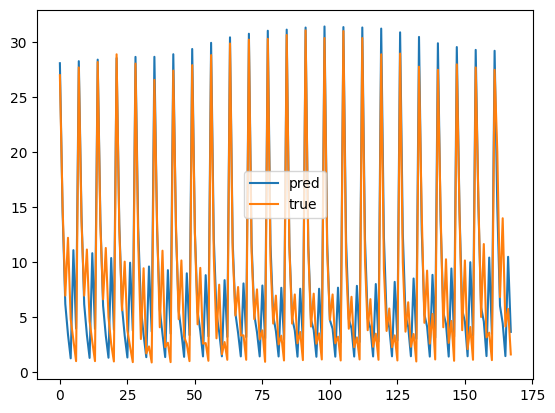

In [20]:
df.plot()